In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import keras_tuner as kt


### Define functions for use during optimization

In [3]:
def reduce_count_vals(df, colname, threshold):
    # Determine which values to replace if counts are less than ...?
    counts = df[colname].value_counts()
    replace_list = list(counts[counts < threshold].index)

    # Replace in dataframe
    for item in replace_list:
       df[colname] = df[colname].replace(item,"Other")
    
    # Check to make sure binning was successful
    df[colname].value_counts()

In [4]:
def do_one_hot(df, y_col):
    # Create a list of columns that are 'object' type
    obj_cat = df.dtypes[df.dtypes == "object"].index.tolist()
    # Create a OneHotEncoder instance
    enc = OneHotEncoder(sparse=False)
    # Fit and transform the OneHotEncoder using the categorical variable list
    encode_df = pd.DataFrame(enc.fit_transform(df[obj_cat]))
    # Add the encoded variable names to the DataFrame
    encode_df.columns = enc.get_feature_names(obj_cat)
    
    # Merge one-hot encoded features and drop the originals
    df = df.merge(encode_df, left_index=True, right_index=True)
    df = df.drop(obj_cat,1)
    
    # Split our preprocessed data into our features and target arrays
    y = df[y_col].values
    df.drop(columns=[y_col], inplace=True)
    X = df.values
    print(f"merged df.shape()={df.shape}")
    
    return df, X, y

In [5]:
def do_scatter_plots(df):
    colnames = ['APPLICATION_TYPE', 
        'AFFILIATION', 
        'CLASSIFICATION', 
        'USE_CASE', 
        'ORGANIZATION', 
        'INCOME_AMT',
        'SPECIAL_CONSIDERATIONS', 
        'ASK_AMT',
    ]
    #fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(24,24))
    for xx in range(0,8):
        for yy in range(xx+1,8):
            #if xx == yy:
            #    continue
            titlestring = f"x={colnames[xx]} vs. y={colnames[yy]}"
            #df.plot.scatter(ax=axes[xx,yy], x=colnames[xx], y=colnames[yy], title=titlestring, c=df['IS_SUCCESSFUL'], s=(df['ASK_AMT']*20), colormap='winter')
            df.plot.scatter(
                figsize=(6,6),
                x=colnames[xx], 
                y=colnames[yy], 
                title=titlestring,
                xlabel=colnames[xx],
                ylabel=colnames[yy],
                c=df['IS_SUCCESSFUL'], 
                s=(df['ASK_AMT']*50), 
                colormap='winter'
            )


In [6]:
def do_scale(scaler):
    # Scale the data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    return X_train_scaled, X_test_scaled

In [7]:
def build_model(inputs, layers):
    nn = tf.keras.models.Sequential()
    first = True
    for layer in layers:
        if first:
            first = False
            nn.add(tf.keras.layers.Dense(units=layer['units'], activation=layer['act'], input_dim=inputs))
        else:
            nn.add(tf.keras.layers.Dense(units=layer['units'], activation=layer['act']))

    print(nn.summary())
    nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return nn

In [8]:
def train_nn_model(model, X_train, y_train, n_epochs, checkpoint_dir):
    # Create a callback that saves the model's weights every epoch
    from tensorflow.keras.callbacks import ModelCheckpoint
    
    # Define the checkpoint path and filenames
    os.makedirs("checkpoints_opt",exist_ok=True)
    #checkpoint_file = f"weights.{epoch:02d}.hdf5"
    #checkpoint_path = f"checkpoints_opt/weights.{epoch:02d}.hdf5"
    checkpoint_path = "checkpoints_opt/weights_2.{epoch:02d}.hdf5"
    
    cp_callback_opt = ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=1,
        save_weights_only=True,
        period=5)

    # Normally we use 'save_freq', but it behaves strangely, and I could not get
    # it to save every 5 epochs. The 'period' param is now deprecated, but it works.
        #save_freq='epoch')
        
    fit_model = model.fit(X_train, y_train, epochs=n_epochs, callbacks=[cp_callback_opt])
    return fit_model

In [9]:
def range_to_int(range_str):
    if range_str == "0":
        return 0
    elif range_str == "1-9999":
        return 9_999 
    elif range_str == "10000-24999":
        return 24_999 
    elif range_str == "25000-99999":
        return 99_999 
    elif range_str == "100000-499999":
        return 499_999 
    elif range_str == "500000-1000000":
        return 1_000_000 
    elif range_str == "500000-1M":
        return 1_000_000 
    elif range_str == "1M-5M":
        return 5_000_000
    elif range_str == "5M-10M":
        return 10_000_000 
    elif range_str == "10M-50M":
        return 50_000_000
    elif range_str == "50M+":
        return 100_000_000 
    else:
        return 11


In [10]:
def chunk_ask(ask):
    if ask == 0:
        return "0"
    elif ask < 9999:
        return "1-9999"
    elif ask < 24999:
        return "10000-24999"
    elif ask < 99999:
        return "25000-99999"
    elif ask < 499999:
        return "100000-499999"
    elif ask < 1000000:
        return "500000-1000000"
    elif ask < 5000000:
        return "1M-5M"
    elif ask < 10000000:
        return "5M-10M"
    elif ask < 50000000:
        return "10M-50M"
    else:
        return "50M+"


In [11]:
def encode_ask(ask):
    if ask < 9999:
        return 1 #return 9_999 // 5000
    elif ask < 24999:
        return 2 #return 24_999 // 5000
    elif ask < 99999:
        return 3 #return 99_999 // 5000
    elif ask < 499999:
        return 4 #return 499_999 // 5000
    elif ask < 1000000:
        return 5 #return 1_000_000 // 5000
    elif ask < 5000000:
        return 6 #return 5_000_000 // 5000
    elif ask < 10000000:
        return 7 #return 10_000_000 // 5000
    elif ask < 50000000:
        return 8 #return 50_000_000 // 5000
    else:
        return 9 #return 100_000_000 // 5000


In [12]:
# Create a method that creates a new Sequential model with hyperparameter options

def create_tuner_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=70,
        max_value=140,
        step=10), activation=activation, input_dim=40))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for ii in range(hp.Int('num_layers', 1, 10)):
        #nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(ii),
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(ii),                                             
            min_value=70,
            max_value=140,
            step=10),
            activation=activation))
            
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [13]:
def run_keras_tuner(X_train, y_train, n_epochs, validation_data):
    # Create a `Hyperband()` tuner instance
    tuner = kt.Hyperband(
        create_tuner_model,
        objective="val_accuracy",
        max_epochs=50,
        hyperband_iterations=2,
        overwrite=True)

    # Run the kerastuner search for best hyperparameters
    tuner.search(X_train, y_train, epochs=n_epochs, validation_data=validation_data)
    return tuner

In [14]:
def bin_names(name,map,counter):
    if name in map:
        return map[name]
    else:
        counter[0] = counter[0] + 1
        map[name] = counter[0]
        return map[name]

### Optimation Run 1 - With 7 layers of tanh & sigmoid

In [15]:
application_df = pd.read_csv("Resources/charity_data.csv")
csv_cols = [
    'EIN', 
    'NAME', 
    'APPLICATION_TYPE', 
    'AFFILIATION', 
    'CLASSIFICATION', 
    'USE_CASE', 
    'ORGANIZATION', 
    'STATUS', 
    'INCOME_AMT', 
    'SPECIAL_CONSIDERATIONS', 
    'ASK_AMT', 
    'IS_SUCCESSFUL'
]
application_df.drop(columns=['EIN', 'NAME'], inplace=True)

reduce_count_vals(application_df, 'APPLICATION_TYPE', 500)
reduce_count_vals(application_df, 'CLASSIFICATION', 1500)

application_df, X, y = do_one_hot(application_df, 'IS_SUCCESSFUL')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
X_train_scaled, X_test_scaled = do_scale(StandardScaler())
#X_train_scaled, X_test_scaled = do_scale(MinMaxScaler())

nins = application_df.shape[1]
print(f"nins={nins}")
nn_model = build_model(inputs=nins, layers=[
    {'units': 340, 'act': 'tanh'},
    {'units': 170, 'act': 'tanh'},
    {'units': 85,  'act': 'tanh'},
    {'units': 40,  'act': 'tanh'},
    {'units': 20,  'act': 'sigmoid'},
    {'units': 5,   'act': 'sigmoid'},
    {'units': 1,   'act': 'sigmoid'}
])
trained_model = train_nn_model(nn_model, X_train_scaled, y_train, n_epochs=500, checkpoint_dir="checkpoints_opt")

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# Export our model to HDF5 file
nn_model.save("AlphabetSoupCharity_opt1.h5")


C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  del sys.path[0]


merged df.shape()=(34299, 43)
nins=43
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 340)               14960     
_________________________________________________________________
dense_1 (Dense)              (None, 170)               57970     
_________________________________________________________________
dense_2 (Dense)              (None, 85)                14535     
_________________________________________________________________
dense_3 (Dense)              (None, 40)                3440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_6 (Dense)   

804/804 [==============================] - 1s 2ms/step - loss: 0.5368 - accuracy: 0.7407

Epoch 00060: saving model to checkpoints_opt\weights_2.60.hdf5
Epoch 61/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5369 - accuracy: 0.7407
Epoch 62/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5362 - accuracy: 0.7410: 0s - loss:
Epoch 63/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5366 - accuracy: 0.7401
Epoch 64/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5367 - accuracy: 0.7411
Epoch 65/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5374 - accuracy: 0.7394

Epoch 00065: saving model to checkpoints_opt\weights_2.65.hdf5
Epoch 66/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5372 - accuracy: 0.7408
Epoch 67/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5362 - accuracy: 0.7406
Epoch 68/500
804/804 [==============================] - 1

Epoch 131/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5340 - accuracy: 0.7427
Epoch 132/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5345 - accuracy: 0.7415
Epoch 133/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5341 - accuracy: 0.7413
Epoch 134/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5345 - accuracy: 0.7410
Epoch 135/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5339 - accuracy: 0.7415

Epoch 00135: saving model to checkpoints_opt\weights_2.135.hdf5
Epoch 136/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5341 - accuracy: 0.7413
Epoch 137/500
804/804 [==============================] - 2s 3ms/step - loss: 0.5344 - accuracy: 0.7412
Epoch 138/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5339 - accuracy: 0.7420
Epoch 139/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5346 - accuracy: 0.7419
Epoch 14

804/804 [==============================] - 2s 2ms/step - loss: 0.5331 - accuracy: 0.7422
Epoch 202/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5335 - accuracy: 0.7415
Epoch 203/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5334 - accuracy: 0.7425
Epoch 204/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5332 - accuracy: 0.7415
Epoch 205/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5332 - accuracy: 0.7423

Epoch 00205: saving model to checkpoints_opt\weights_2.205.hdf5
Epoch 206/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5330 - accuracy: 0.7415
Epoch 207/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5344 - accuracy: 0.7418
Epoch 208/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5340 - accuracy: 0.7419
Epoch 209/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5332 - accuracy: 0.7416
Epoch 210/500
804/804 

804/804 [==============================] - 2s 2ms/step - loss: 0.5328 - accuracy: 0.7424
Epoch 272/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5328 - accuracy: 0.7418
Epoch 273/500
804/804 [==============================] - 2s 3ms/step - loss: 0.5329 - accuracy: 0.7427
Epoch 274/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5330 - accuracy: 0.7425
Epoch 275/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5330 - accuracy: 0.7421

Epoch 00275: saving model to checkpoints_opt\weights_2.275.hdf5
Epoch 276/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5329 - accuracy: 0.7416
Epoch 277/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5325 - accuracy: 0.7423
Epoch 278/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5331 - accuracy: 0.7422
Epoch 279/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5326 - accuracy: 0.7414
Epoch 280/500
804/804 

804/804 [==============================] - 2s 2ms/step - loss: 0.5327 - accuracy: 0.7427
Epoch 342/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5325 - accuracy: 0.7417
Epoch 343/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5327 - accuracy: 0.7419
Epoch 344/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5324 - accuracy: 0.7420
Epoch 345/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5330 - accuracy: 0.7408

Epoch 00345: saving model to checkpoints_opt\weights_2.345.hdf5
Epoch 346/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5340 - accuracy: 0.7407
Epoch 347/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5342 - accuracy: 0.7414
Epoch 348/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5330 - accuracy: 0.7412
Epoch 349/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5330 - accuracy: 0.7416
Epoch 350/500
804/804 

804/804 [==============================] - 2s 3ms/step - loss: 0.5334 - accuracy: 0.7422
Epoch 412/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5334 - accuracy: 0.7395
Epoch 413/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5329 - accuracy: 0.7414
Epoch 414/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5339 - accuracy: 0.7409
Epoch 415/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5344 - accuracy: 0.7403

Epoch 00415: saving model to checkpoints_opt\weights_2.415.hdf5
Epoch 416/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5340 - accuracy: 0.7409
Epoch 417/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5327 - accuracy: 0.7418
Epoch 418/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5323 - accuracy: 0.7412
Epoch 419/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5325 - accuracy: 0.7417
Epoch 420/500
804/804 

804/804 [==============================] - 2s 2ms/step - loss: 0.5339 - accuracy: 0.7422
Epoch 482/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5337 - accuracy: 0.7424
Epoch 483/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5330 - accuracy: 0.7428
Epoch 484/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5330 - accuracy: 0.7421
Epoch 485/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5333 - accuracy: 0.7409

Epoch 00485: saving model to checkpoints_opt\weights_2.485.hdf5
Epoch 486/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5335 - accuracy: 0.7419
Epoch 487/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5331 - accuracy: 0.7418
Epoch 488/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5330 - accuracy: 0.7420
Epoch 489/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5333 - accuracy: 0.7419
Epoch 490/500
804/804 

### Optimization Run 2 - Same as Run1, but drop 'STATUS' & 'SPECIAL_CONSIDERATIONS'; and bucketize 'AFFILIATION', 'ORGANIZATION', AND 'INCOME_AMT'

In [16]:
application_df = pd.read_csv("Resources/charity_data.csv")
csv_cols = [
    'EIN', 
    'NAME', 
    'APPLICATION_TYPE', 
    'AFFILIATION', 
    'CLASSIFICATION', 
    'USE_CASE', 
    'ORGANIZATION', 
    'STATUS', 
    'INCOME_AMT', 
    'SPECIAL_CONSIDERATIONS', 
    'ASK_AMT', 
    'IS_SUCCESSFUL'
]

application_df.drop(columns=['EIN', 'NAME','STATUS', 'SPECIAL_CONSIDERATIONS'], inplace=True)

reduce_count_vals(application_df, 'APPLICATION_TYPE', 500)
reduce_count_vals(application_df, 'CLASSIFICATION', 1500)
reduce_count_vals(application_df, 'AFFILIATION', 100)
reduce_count_vals(application_df, 'ORGANIZATION', 500)
reduce_count_vals(application_df, 'INCOME_AMT', 500)

application_df, X, y = do_one_hot(application_df, 'IS_SUCCESSFUL')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
#X_train_scaled, X_test_scaled = do_scale(StandardScaler())
X_train_scaled, X_test_scaled = do_scale(MinMaxScaler())

nins = application_df.shape[1]
print(f"nins={nins}")
nn_model = build_model(inputs=nins, layers=[
    {'units': 340, 'act': 'relu'},
    {'units': 170, 'act': 'relu'},
    {'units': 85,  'act': 'relu'},
    {'units': 40,  'act': 'relu'},
    {'units': 20,  'act': 'sigmoid'},
    {'units': 5,   'act': 'sigmoid'},
    {'units': 1,   'act': 'sigmoid'}
])
trained_model = train_nn_model(nn_model, X_train_scaled, y_train, n_epochs=500, checkpoint_dir="checkpoints_opt")

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# Export our model to HDF5 file
nn_model.save("AlphabetSoupCharity_opt2.h5")

merged df.shape()=(34299, 34)
nins=34
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 340)               11900     
_________________________________________________________________
dense_8 (Dense)              (None, 170)               57970     
_________________________________________________________________
dense_9 (Dense)              (None, 85)                14535     
_________________________________________________________________
dense_10 (Dense)             (None, 40)                3440      
_________________________________________________________________
dense_11 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_13 (Dense)

C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  del sys.path[0]


Epoch 1/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5918 - accuracy: 0.7133
Epoch 2/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5621 - accuracy: 0.7303
Epoch 3/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5573 - accuracy: 0.7308
Epoch 4/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5553 - accuracy: 0.7325
Epoch 5/500
804/804 [==============================] - 2s 3ms/step - loss: 0.5524 - accuracy: 0.7340

Epoch 00005: saving model to checkpoints_opt\weights_2.05.hdf5
Epoch 6/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5509 - accuracy: 0.7348
Epoch 7/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5501 - accuracy: 0.7340
Epoch 8/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5486 - accuracy: 0.7357
Epoch 9/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5480 - accuracy: 0.7352
Epoch 10/500
804/804 [=====

804/804 [==============================] - 2s 2ms/step - loss: 0.5363 - accuracy: 0.7404
Epoch 73/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5362 - accuracy: 0.7413
Epoch 74/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5365 - accuracy: 0.7410
Epoch 75/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5362 - accuracy: 0.7410

Epoch 00075: saving model to checkpoints_opt\weights_2.75.hdf5
Epoch 76/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5361 - accuracy: 0.7410
Epoch 77/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5357 - accuracy: 0.7413
Epoch 78/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5356 - accuracy: 0.7405
Epoch 79/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5376 - accuracy: 0.7400
Epoch 80/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5359 - accuracy: 0.7409

Epoch 00080: saving model to c

804/804 [==============================] - 1s 2ms/step - loss: 0.5380 - accuracy: 0.7409
Epoch 144/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5366 - accuracy: 0.7407
Epoch 145/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5364 - accuracy: 0.7413

Epoch 00145: saving model to checkpoints_opt\weights_2.145.hdf5
Epoch 146/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5359 - accuracy: 0.7411
Epoch 147/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5354 - accuracy: 0.7414
Epoch 148/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5358 - accuracy: 0.7412
Epoch 149/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5353 - accuracy: 0.7410
Epoch 150/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5354 - accuracy: 0.7418

Epoch 00150: saving model to checkpoints_opt\weights_2.150.hdf5
Epoch 151/500
804/804 [==============================] - 2s 

804/804 [==============================] - 1s 2ms/step - loss: 0.5402 - accuracy: 0.7399
Epoch 214/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5420 - accuracy: 0.7386
Epoch 215/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5389 - accuracy: 0.7404

Epoch 00215: saving model to checkpoints_opt\weights_2.215.hdf5
Epoch 216/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5389 - accuracy: 0.7414
Epoch 217/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5387 - accuracy: 0.7415
Epoch 218/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5405 - accuracy: 0.7404
Epoch 219/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5395 - accuracy: 0.7410
Epoch 220/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5396 - accuracy: 0.7404

Epoch 00220: saving model to checkpoints_opt\weights_2.220.hdf5
Epoch 221/500
804/804 [==============================] - 2s 

804/804 [==============================] - 2s 2ms/step - loss: 0.5449 - accuracy: 0.7405
Epoch 284/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5442 - accuracy: 0.7398
Epoch 285/500
804/804 [==============================] - 2s 3ms/step - loss: 0.5428 - accuracy: 0.7405

Epoch 00285: saving model to checkpoints_opt\weights_2.285.hdf5
Epoch 286/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5435 - accuracy: 0.7409
Epoch 287/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5438 - accuracy: 0.7393
Epoch 288/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5425 - accuracy: 0.7401
Epoch 289/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5425 - accuracy: 0.7395
Epoch 290/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5414 - accuracy: 0.7403

Epoch 00290: saving model to checkpoints_opt\weights_2.290.hdf5
Epoch 291/500
804/804 [==============================] - 2s 

804/804 [==============================] - 2s 2ms/step - loss: 0.5546 - accuracy: 0.7376
Epoch 354/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5543 - accuracy: 0.7362
Epoch 355/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5574 - accuracy: 0.7355

Epoch 00355: saving model to checkpoints_opt\weights_2.355.hdf5
Epoch 356/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5588 - accuracy: 0.7374
Epoch 357/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5577 - accuracy: 0.7378
Epoch 358/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5568 - accuracy: 0.7376
Epoch 359/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5557 - accuracy: 0.7382
Epoch 360/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5567 - accuracy: 0.7365

Epoch 00360: saving model to checkpoints_opt\weights_2.360.hdf5
Epoch 361/500
804/804 [==============================] - 2s 

804/804 [==============================] - 2s 2ms/step - loss: 0.5558 - accuracy: 0.7336
Epoch 424/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5583 - accuracy: 0.7327
Epoch 425/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5593 - accuracy: 0.7331

Epoch 00425: saving model to checkpoints_opt\weights_2.425.hdf5
Epoch 426/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5657 - accuracy: 0.7329
Epoch 427/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5699 - accuracy: 0.7315
Epoch 428/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5805 - accuracy: 0.7241
Epoch 429/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5625 - accuracy: 0.7332
Epoch 430/500
804/804 [==============================] - 1s 2ms/step - loss: 0.5595 - accuracy: 0.7331

Epoch 00430: saving model to checkpoints_opt\weights_2.430.hdf5
Epoch 431/500
804/804 [==============================] - 2s 

804/804 [==============================] - 2s 2ms/step - loss: 0.6657 - accuracy: 0.5775
Epoch 494/500
804/804 [==============================] - 1s 2ms/step - loss: 0.6657 - accuracy: 0.5773
Epoch 495/500
804/804 [==============================] - 2s 2ms/step - loss: 0.6657 - accuracy: 0.5774

Epoch 00495: saving model to checkpoints_opt\weights_2.495.hdf5
Epoch 496/500
804/804 [==============================] - 2s 2ms/step - loss: 0.6657 - accuracy: 0.5774
Epoch 497/500
804/804 [==============================] - 2s 2ms/step - loss: 0.6657 - accuracy: 0.5774
Epoch 498/500
804/804 [==============================] - 2s 2ms/step - loss: 0.6657 - accuracy: 0.5773
Epoch 499/500
804/804 [==============================] - 1s 2ms/step - loss: 0.6656 - accuracy: 0.5774
Epoch 500/500
804/804 [==============================] - 2s 2ms/step - loss: 0.6657 - accuracy: 0.5774

Epoch 00500: saving model to checkpoints_opt\weights_2.500.hdf5
268/268 - 0s - loss: 0.6642 - accuracy: 0.5785
Loss: 0.66420

### Optimization Run 3 - with KerasTuner

In [17]:
application_df = pd.read_csv("Resources/charity_data.csv")
csv_cols = [
    'EIN', 
    'NAME', 
    'APPLICATION_TYPE', 
    'AFFILIATION', 
    'CLASSIFICATION', 
    'USE_CASE', 
    'ORGANIZATION', 
    'STATUS', 
    'INCOME_AMT', 
    'SPECIAL_CONSIDERATIONS', 
    'ASK_AMT', 
    'IS_SUCCESSFUL'
]

application_df.drop(columns=['EIN', 'NAME','STATUS', 'SPECIAL_CONSIDERATIONS'], inplace=True)

reduce_count_vals(application_df, 'APPLICATION_TYPE', 500)
reduce_count_vals(application_df, 'CLASSIFICATION', 1500)

application_df, X, y = do_one_hot(application_df, 'IS_SUCCESSFUL')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
X_train_scaled, X_test_scaled = do_scale(StandardScaler())
#X_train_scaled, X_test_scaled = do_scale(MinMaxScaler())

nins = application_df.shape[1]
print(f"nins={nins}")

tuner = run_keras_tuner(X_train_scaled, y_train, n_epochs=20, validation_data=(X_test_scaled,y_test))

# # Evaluate the model using the test data
# model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# Export our model to HDF5 file
nn_model.save("AlphabetSoupCharity_opt3.h5")

Trial 180 Complete [00h 02m 33s]
val_accuracy: 0.5331778526306152

Best val_accuracy So Far: 0.72967928647995
Total elapsed time: 01h 13m 59s
INFO:tensorflow:Oracle triggered exit


In [18]:
# Get top 3 model hyperparameters and print the values
best_hypers = []
for ii in range(1,4):
    best_hyper = tuner.get_best_hyperparameters(ii)[0]
    print(best_hyper.values)
    best_hypers.append(best_hyper)

{'activation': 'relu', 'first_units': 80, 'num_layers': 6, 'units_0': 90, 'units_1': 100, 'units_2': 120, 'units_3': 90, 'units_4': 90, 'units_5': 100, 'units_6': 90, 'units_7': 80, 'units_8': 120, 'units_9': 90, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '2f7a145941325170ecca47c3ca35e929'}
{'activation': 'relu', 'first_units': 80, 'num_layers': 6, 'units_0': 90, 'units_1': 100, 'units_2': 120, 'units_3': 90, 'units_4': 90, 'units_5': 100, 'units_6': 90, 'units_7': 80, 'units_8': 120, 'units_9': 90, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '2f7a145941325170ecca47c3ca35e929'}
{'activation': 'relu', 'first_units': 80, 'num_layers': 6, 'units_0': 90, 'units_1': 100, 'units_2': 120, 'units_3': 90, 'units_4': 90, 'units_5': 100, 'units_6': 90, 'units_7': 80, 'units_8': 120, 'units_9': 90, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 2, 'tuner/round': 1, '

In [19]:
# Evaluate the top 3 models against the test dataset
best_models = []
for ii in range(1,4):
    best_model = tuner.get_best_models(ii)[0]
    model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
    best_models.append(best_model)

268/268 - 1s - loss: 0.5497 - accuracy: 0.7297
Loss: 0.5497153997421265, Accuracy: 0.72967928647995
268/268 - 1s - loss: 0.5497 - accuracy: 0.7297
Loss: 0.5497153997421265, Accuracy: 0.72967928647995
268/268 - 1s - loss: 0.5497 - accuracy: 0.7297
Loss: 0.5497153997421265, Accuracy: 0.72967928647995


### Optimization Run 4 - Bin the Name column

In [20]:
application_df = pd.read_csv("Resources/charity_data.csv")
csv_cols = [
    'EIN', 
    'NAME', 
    'APPLICATION_TYPE', 
    'AFFILIATION', 
    'CLASSIFICATION', 
    'USE_CASE', 
    'ORGANIZATION', 
    'STATUS', 
    'INCOME_AMT', 
    'SPECIAL_CONSIDERATIONS', 
    'ASK_AMT', 
    'IS_SUCCESSFUL'
]
application_df.drop(columns=[
    'EIN',
    'STATUS','SPECIAL_CONSIDERATIONS',
    #'USE_CASE','AFFILIATION','INCOME_AMT','ASK_AMT'
    ], inplace=True)

reduce_count_vals(application_df, 'APPLICATION_TYPE', 500)
reduce_count_vals(application_df, 'CLASSIFICATION', 1500)

#application_df["INCOME_AMT"] = application_df["INCOME_AMT"].apply(range_to_int)
#application_df["ASK_AMT"] = application_df["ASK_AMT"].apply(encode_ask)
application_df["ASK_AMT"] = application_df["ASK_AMT"].apply(chunk_ask)
name_map = {}
counter = [0]
application_df['NAME'] = application_df['NAME'].apply(bin_names, args=(name_map,counter))

application_df, X, y = do_one_hot(application_df, 'IS_SUCCESSFUL')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
#X_train_scaled, X_test_scaled = do_scale(StandardScaler())
X_train_scaled, X_test_scaled = do_scale(MinMaxScaler())

nins = application_df.shape[1]
print(f"nins={nins}")
nn_model = build_model(inputs=nins, layers=[
    #{'units': 512, 'act': 'relu'},
    {'units': 256, 'act': 'relu'},
    {'units': 128, 'act': 'relu'},
    {'units': 64, 'act': 'relu'},
    {'units': 32, 'act': 'relu'},
    {'units': 16, 'act': 'relu'},
    {'units': 8, 'act': 'relu'},
    {'units': 4, 'act': 'relu'},
    {'units': 1, 'act': 'sigmoid'},

])
trained_model = train_nn_model(nn_model, X_train_scaled, y_train, n_epochs=1500, checkpoint_dir="checkpoints_opt")

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# Export our model to HDF5 file
nn_model.save("AlphabetSoupCharity_opt4.h5")

C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  del sys.path[0]


merged df.shape()=(34299, 49)
nins=49
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               12800     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)

804/804 [==============================] - 2s 3ms/step - loss: 0.4463 - accuracy: 0.7909
Epoch 59/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.4499 - accuracy: 0.7909
Epoch 60/1500
804/804 [==============================] - 3s 3ms/step - loss: 0.4478 - accuracy: 0.7904

Epoch 00060: saving model to checkpoints_opt\weights_2.60.hdf5
Epoch 61/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4447 - accuracy: 0.7924
Epoch 62/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4481 - accuracy: 0.7912
Epoch 63/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4482 - accuracy: 0.7891
Epoch 64/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4445 - accuracy: 0.7900
Epoch 65/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4441 - accuracy: 0.7910

Epoch 00065: saving model to checkpoints_opt\weights_2.65.hdf5
Epoch 66/1500
804/804 [==============================] - 2s 2m

804/804 [==============================] - 2s 2ms/step - loss: 0.4223 - accuracy: 0.8010
Epoch 129/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.4261 - accuracy: 0.7990
Epoch 130/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4251 - accuracy: 0.7999

Epoch 00130: saving model to checkpoints_opt\weights_2.130.hdf5
Epoch 131/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.4234 - accuracy: 0.8009
Epoch 132/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.4266 - accuracy: 0.7997
Epoch 133/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4225 - accuracy: 0.7993
Epoch 134/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4216 - accuracy: 0.8005
Epoch 135/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4229 - accuracy: 0.7988

Epoch 00135: saving model to checkpoints_opt\weights_2.135.hdf5
Epoch 136/1500
804/804 [=============================

804/804 [==============================] - 2s 2ms/step - loss: 0.4103 - accuracy: 0.8067
Epoch 199/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4087 - accuracy: 0.8066
Epoch 200/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4104 - accuracy: 0.8064

Epoch 00200: saving model to checkpoints_opt\weights_2.200.hdf5
Epoch 201/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4138 - accuracy: 0.8035
Epoch 202/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.4100 - accuracy: 0.8047
Epoch 203/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.4115 - accuracy: 0.8054
Epoch 204/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4091 - accuracy: 0.8044
Epoch 205/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4130 - accuracy: 0.8042

Epoch 00205: saving model to checkpoints_opt\weights_2.205.hdf5
Epoch 206/1500
804/804 [=============================

804/804 [==============================] - 2s 2ms/step - loss: 0.4052 - accuracy: 0.8060
Epoch 269/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4063 - accuracy: 0.8087
Epoch 270/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4039 - accuracy: 0.8090

Epoch 00270: saving model to checkpoints_opt\weights_2.270.hdf5
Epoch 271/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4079 - accuracy: 0.8071
Epoch 272/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4050 - accuracy: 0.8085
Epoch 273/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4080 - accuracy: 0.8083
Epoch 274/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4100 - accuracy: 0.8047
Epoch 275/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4084 - accuracy: 0.8068

Epoch 00275: saving model to checkpoints_opt\weights_2.275.hdf5
Epoch 276/1500
804/804 [=============================

804/804 [==============================] - 2s 2ms/step - loss: 0.3962 - accuracy: 0.8125
Epoch 339/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3987 - accuracy: 0.8113
Epoch 340/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3982 - accuracy: 0.8117

Epoch 00340: saving model to checkpoints_opt\weights_2.340.hdf5
Epoch 341/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3988 - accuracy: 0.8116
Epoch 342/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4031 - accuracy: 0.8073
Epoch 343/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3998 - accuracy: 0.8105
Epoch 344/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3956 - accuracy: 0.8121
Epoch 345/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3961 - accuracy: 0.8134

Epoch 00345: saving model to checkpoints_opt\weights_2.345.hdf5
Epoch 346/1500
804/804 [=============================

804/804 [==============================] - 2s 2ms/step - loss: 0.3972 - accuracy: 0.8104
Epoch 409/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3989 - accuracy: 0.8096
Epoch 410/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3962 - accuracy: 0.8109

Epoch 00410: saving model to checkpoints_opt\weights_2.410.hdf5
Epoch 411/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3963 - accuracy: 0.8146
Epoch 412/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3961 - accuracy: 0.8120: 0s - loss: 0.3965 - accu
Epoch 413/1500
804/804 [==============================] - 1s 2ms/step - loss: 0.3945 - accuracy: 0.8126
Epoch 414/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3938 - accuracy: 0.8096
Epoch 415/1500
804/804 [==============================] - 1s 2ms/step - loss: 0.3957 - accuracy: 0.8127

Epoch 00415: saving model to checkpoints_opt\weights_2.415.hdf5
Epoch 416/1500
804/804 [===

804/804 [==============================] - 2s 2ms/step - loss: 0.3941 - accuracy: 0.8132
Epoch 478/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3900 - accuracy: 0.8157
Epoch 479/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3906 - accuracy: 0.8156
Epoch 480/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3881 - accuracy: 0.8168

Epoch 00480: saving model to checkpoints_opt\weights_2.480.hdf5
Epoch 481/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3936 - accuracy: 0.8137
Epoch 482/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.4006 - accuracy: 0.8125
Epoch 483/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3964 - accuracy: 0.8142
Epoch 484/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3974 - accuracy: 0.8140
Epoch 485/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3932 - accuracy: 0.8141

Epoch 00485: 

804/804 [==============================] - 2s 3ms/step - loss: 0.3920 - accuracy: 0.8137
Epoch 547/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3950 - accuracy: 0.8135
Epoch 548/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3936 - accuracy: 0.8146
Epoch 549/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3941 - accuracy: 0.8141
Epoch 550/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3880 - accuracy: 0.8162

Epoch 00550: saving model to checkpoints_opt\weights_2.550.hdf5
Epoch 551/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3860 - accuracy: 0.8171
Epoch 552/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3875 - accuracy: 0.8156
Epoch 553/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3881 - accuracy: 0.8164
Epoch 554/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3871 - accuracy: 0.8180
Epoch 555/1500

804/804 [==============================] - 2s 3ms/step - loss: 0.3823 - accuracy: 0.8209
Epoch 617/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3822 - accuracy: 0.8200
Epoch 618/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3820 - accuracy: 0.8205
Epoch 619/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3970 - accuracy: 0.8076
Epoch 620/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3903 - accuracy: 0.8093

Epoch 00620: saving model to checkpoints_opt\weights_2.620.hdf5
Epoch 621/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3863 - accuracy: 0.8107
Epoch 622/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3870 - accuracy: 0.8155
Epoch 623/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3855 - accuracy: 0.8173
Epoch 624/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3818 - accuracy: 0.8189
Epoch 625/1500

804/804 [==============================] - 2s 3ms/step - loss: 0.3770 - accuracy: 0.8215
Epoch 687/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3793 - accuracy: 0.8190
Epoch 688/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3797 - accuracy: 0.8190
Epoch 689/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3775 - accuracy: 0.8219
Epoch 690/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3795 - accuracy: 0.8200

Epoch 00690: saving model to checkpoints_opt\weights_2.690.hdf5
Epoch 691/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3769 - accuracy: 0.8211
Epoch 692/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3827 - accuracy: 0.8187
Epoch 693/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3820 - accuracy: 0.8184
Epoch 694/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3764 - accuracy: 0.8210
Epoch 695/1500

Epoch 756/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3742 - accuracy: 0.8233
Epoch 757/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3776 - accuracy: 0.8221
Epoch 758/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3783 - accuracy: 0.8204
Epoch 759/1500
804/804 [==============================] - 1s 2ms/step - loss: 0.3851 - accuracy: 0.8180
Epoch 760/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3772 - accuracy: 0.8220

Epoch 00760: saving model to checkpoints_opt\weights_2.760.hdf5
Epoch 761/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3735 - accuracy: 0.8220
Epoch 762/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3805 - accuracy: 0.8213
Epoch 763/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3782 - accuracy: 0.8220
Epoch 764/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3812 - accuracy: 0.8204

Epoch 826/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3730 - accuracy: 0.8235
Epoch 827/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3791 - accuracy: 0.8198
Epoch 828/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3748 - accuracy: 0.8218
Epoch 829/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3726 - accuracy: 0.8229
Epoch 830/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3731 - accuracy: 0.8227

Epoch 00830: saving model to checkpoints_opt\weights_2.830.hdf5
Epoch 831/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3762 - accuracy: 0.8230
Epoch 832/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3755 - accuracy: 0.8220
Epoch 833/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3731 - accuracy: 0.8237
Epoch 834/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3773 - accuracy: 0.8212

Epoch 896/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3790 - accuracy: 0.8183
Epoch 897/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3800 - accuracy: 0.8161
Epoch 898/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3757 - accuracy: 0.8190
Epoch 899/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3760 - accuracy: 0.8184
Epoch 900/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3765 - accuracy: 0.8165

Epoch 00900: saving model to checkpoints_opt\weights_2.900.hdf5
Epoch 901/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3756 - accuracy: 0.8184
Epoch 902/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3778 - accuracy: 0.8188
Epoch 903/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3701 - accuracy: 0.8220
Epoch 904/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3722 - accuracy: 0.8206

Epoch 966/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3703 - accuracy: 0.8226
Epoch 967/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3717 - accuracy: 0.8233
Epoch 968/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3706 - accuracy: 0.8235
Epoch 969/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3704 - accuracy: 0.8215
Epoch 970/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3738 - accuracy: 0.8209

Epoch 00970: saving model to checkpoints_opt\weights_2.970.hdf5
Epoch 971/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3678 - accuracy: 0.8251
Epoch 972/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3658 - accuracy: 0.8259
Epoch 973/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3708 - accuracy: 0.8244
Epoch 974/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3684 - accuracy: 0.8228

804/804 [==============================] - 2s 2ms/step - loss: 0.3732 - accuracy: 0.8236
Epoch 1037/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3683 - accuracy: 0.8245
Epoch 1038/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3685 - accuracy: 0.8247
Epoch 1039/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3690 - accuracy: 0.8240
Epoch 1040/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3687 - accuracy: 0.8241

Epoch 01040: saving model to checkpoints_opt\weights_2.1040.hdf5
Epoch 1041/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3708 - accuracy: 0.8221
Epoch 1042/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3670 - accuracy: 0.8249
Epoch 1043/1500
804/804 [==============================] - 1s 2ms/step - loss: 0.3703 - accuracy: 0.8245
Epoch 1044/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3660 - accuracy: 0.8243
Epoch

804/804 [==============================] - 2s 2ms/step - loss: 0.3673 - accuracy: 0.8268

Epoch 01105: saving model to checkpoints_opt\weights_2.1105.hdf5
Epoch 1106/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3674 - accuracy: 0.8244
Epoch 1107/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3688 - accuracy: 0.8246
Epoch 1108/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3688 - accuracy: 0.8217
Epoch 1109/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3635 - accuracy: 0.8266
Epoch 1110/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3690 - accuracy: 0.8236

Epoch 01110: saving model to checkpoints_opt\weights_2.1110.hdf5
Epoch 1111/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3667 - accuracy: 0.8251
Epoch 1112/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3684 - accuracy: 0.8230
Epoch 1113/1500
804/804 [===================

804/804 [==============================] - 3s 3ms/step - loss: 0.3642 - accuracy: 0.8272
Epoch 1174/1500
804/804 [==============================] - 2s 3ms/step - loss: 0.3790 - accuracy: 0.8241
Epoch 1175/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3729 - accuracy: 0.8243

Epoch 01175: saving model to checkpoints_opt\weights_2.1175.hdf5
Epoch 1176/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3727 - accuracy: 0.8253
Epoch 1177/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3730 - accuracy: 0.8236
Epoch 1178/1500
804/804 [==============================] - 3s 3ms/step - loss: 0.3751 - accuracy: 0.8249
Epoch 1179/1500
804/804 [==============================] - 3s 4ms/step - loss: 0.3758 - accuracy: 0.8237
Epoch 1180/1500
804/804 [==============================] - 3s 4ms/step - loss: 0.3772 - accuracy: 0.8227

Epoch 01180: saving model to checkpoints_opt\weights_2.1180.hdf5
Epoch 1181/1500
804/804 [===================

804/804 [==============================] - 2s 2ms/step - loss: 0.3633 - accuracy: 0.8286
Epoch 1243/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3635 - accuracy: 0.8262
Epoch 1244/1500
804/804 [==============================] - 1s 2ms/step - loss: 0.3638 - accuracy: 0.8270
Epoch 1245/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3596 - accuracy: 0.8303

Epoch 01245: saving model to checkpoints_opt\weights_2.1245.hdf5
Epoch 1246/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3657 - accuracy: 0.8259
Epoch 1247/1500
804/804 [==============================] - 1s 2ms/step - loss: 0.3638 - accuracy: 0.8272
Epoch 1248/1500
804/804 [==============================] - 1s 2ms/step - loss: 0.3591 - accuracy: 0.8295
Epoch 1249/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3661 - accuracy: 0.8254
Epoch 1250/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3655 - accuracy: 0.8271

Epoc

804/804 [==============================] - 2s 2ms/step - loss: 0.3635 - accuracy: 0.8271
Epoch 1312/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3613 - accuracy: 0.8271
Epoch 1313/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3671 - accuracy: 0.8257
Epoch 1314/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3634 - accuracy: 0.8289
Epoch 1315/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3619 - accuracy: 0.8277

Epoch 01315: saving model to checkpoints_opt\weights_2.1315.hdf5
Epoch 1316/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3611 - accuracy: 0.8283
Epoch 1317/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3699 - accuracy: 0.8235
Epoch 1318/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3699 - accuracy: 0.8197
Epoch 1319/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3667 - accuracy: 0.8198
Epoch

804/804 [==============================] - 2s 2ms/step - loss: 0.3692 - accuracy: 0.8267
Epoch 1382/1500
804/804 [==============================] - 1s 2ms/step - loss: 0.3707 - accuracy: 0.8253
Epoch 1383/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3705 - accuracy: 0.8250
Epoch 1384/1500
804/804 [==============================] - 1s 2ms/step - loss: 0.3749 - accuracy: 0.8239
Epoch 1385/1500
804/804 [==============================] - 1s 2ms/step - loss: 0.3700 - accuracy: 0.8274

Epoch 01385: saving model to checkpoints_opt\weights_2.1385.hdf5
Epoch 1386/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3725 - accuracy: 0.8251
Epoch 1387/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3719 - accuracy: 0.8245
Epoch 1388/1500
804/804 [==============================] - 1s 2ms/step - loss: 0.3769 - accuracy: 0.8218
Epoch 1389/1500
804/804 [==============================] - 3s 3ms/step - loss: 0.3706 - accuracy: 0.8251
Epoch

Epoch 1451/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3714 - accuracy: 0.8255
Epoch 1452/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3734 - accuracy: 0.8238
Epoch 1453/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3751 - accuracy: 0.8228
Epoch 1454/1500
804/804 [==============================] - 1s 2ms/step - loss: 0.3731 - accuracy: 0.8237
Epoch 1455/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3691 - accuracy: 0.8232

Epoch 01455: saving model to checkpoints_opt\weights_2.1455.hdf5
Epoch 1456/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3698 - accuracy: 0.8231
Epoch 1457/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3719 - accuracy: 0.8244
Epoch 1458/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3705 - accuracy: 0.8235
Epoch 1459/1500
804/804 [==============================] - 2s 2ms/step - loss: 0.3677 - accura

### Create scatter plots

C:\Users\bjile\anaconda3\envs\mlenv\lib\site-packages\pandas\plotting\_matplotlib\core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


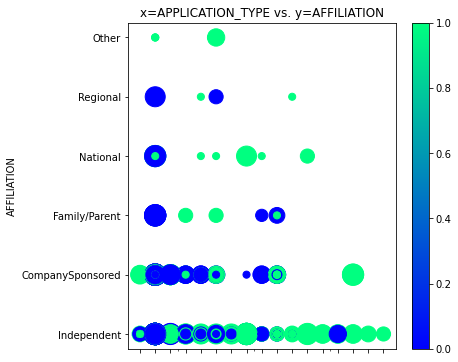

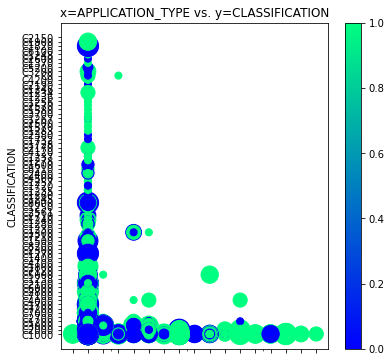

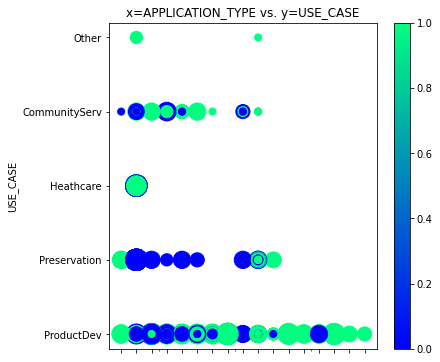

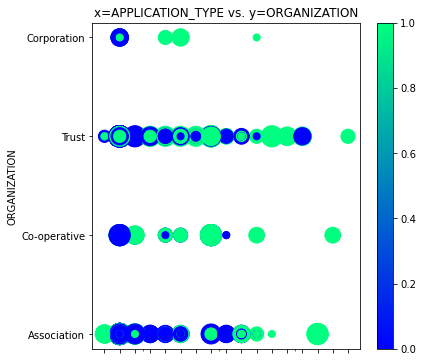

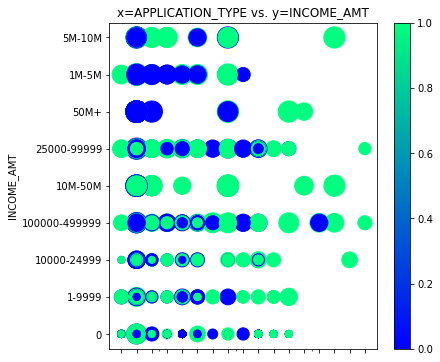

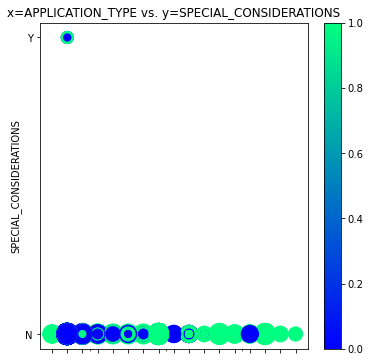

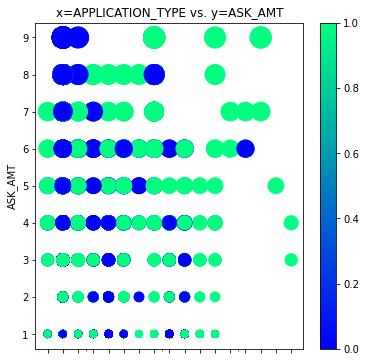

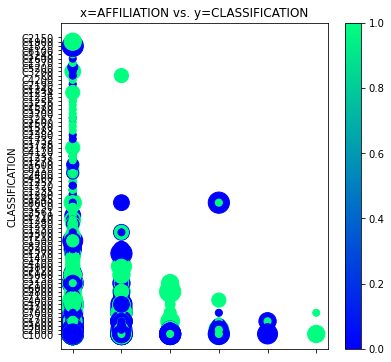

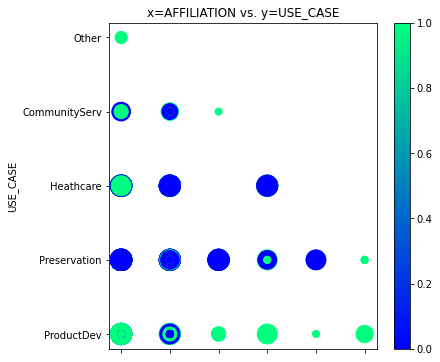

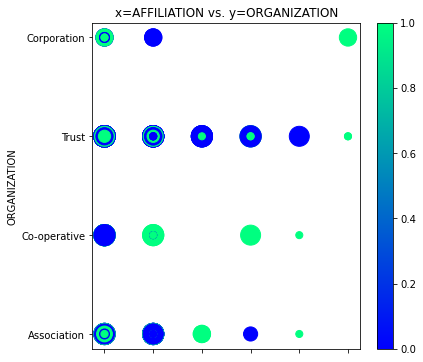

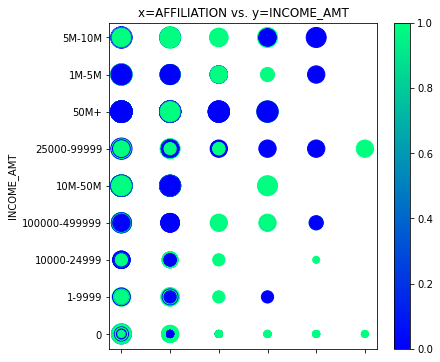

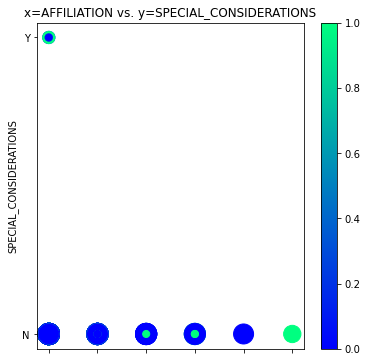

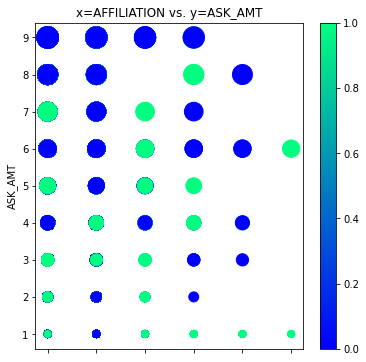

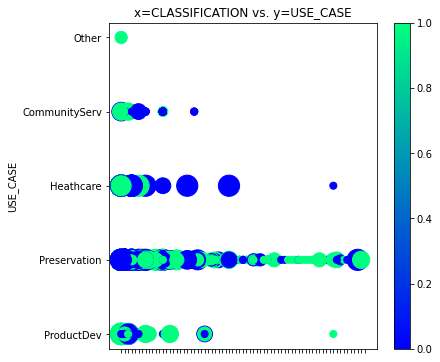

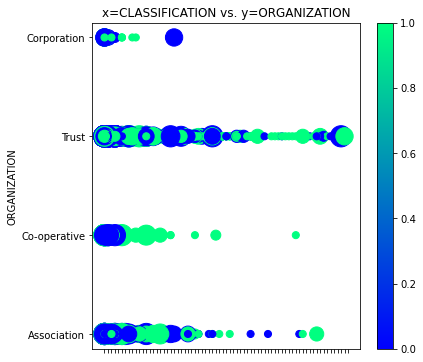

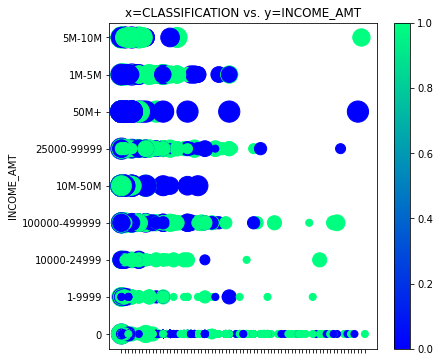

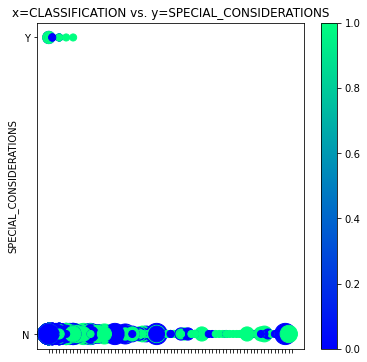

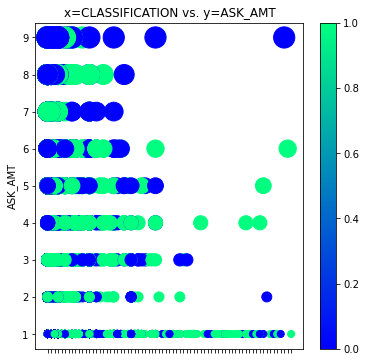

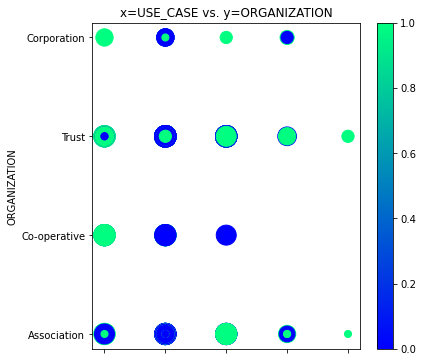

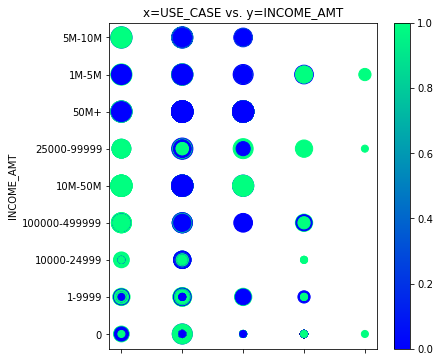

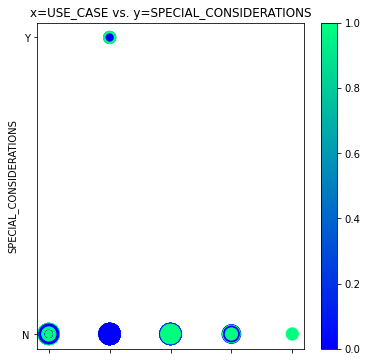

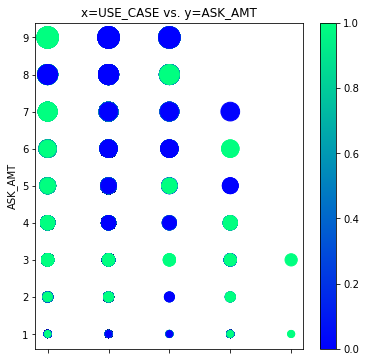

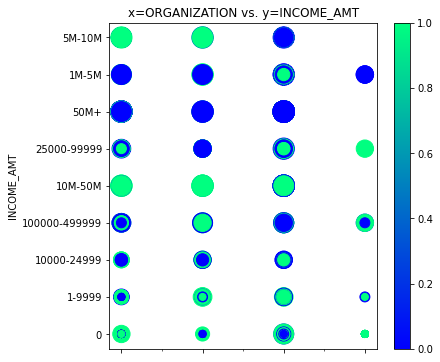

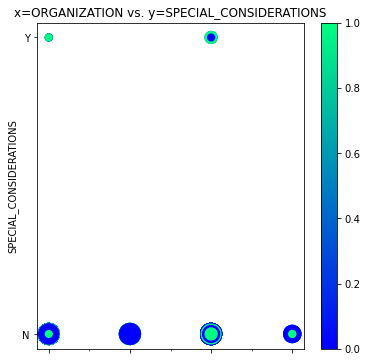

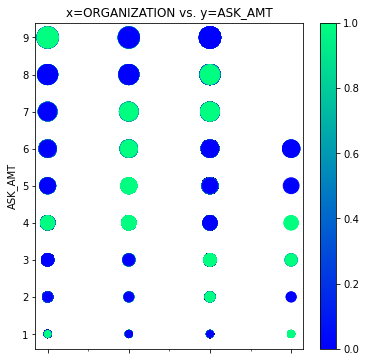

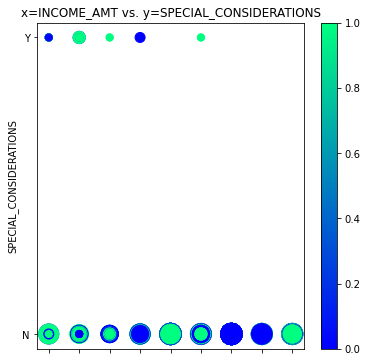

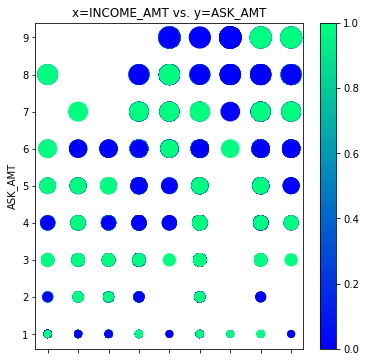

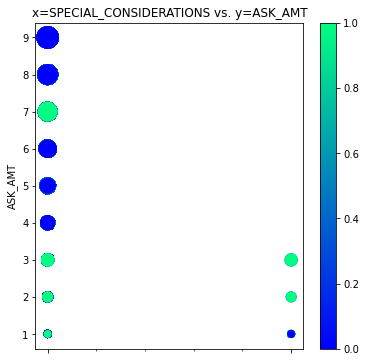

In [21]:
%matplotlib inline
application_df  = pd.read_csv("Resources/charity_data.csv")
application_df.drop(columns=['EIN', 'NAME'], inplace=True)
application_df["ASK_AMT"] = application_df["ASK_AMT"].apply(encode_ask)

do_scatter_plots(application_df)